In [1]:
import os.path

import accelerator_environments
import gym
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise

In [2]:
env = gym.make("ARESEA-JOSS-v0")

env = accelerator_environments.wrappers.NormalizeAction(env)
env = accelerator_environments.wrappers.NormalizeObservation(env)
env = accelerator_environments.wrappers.NormalizeReward(env)

env

initializing ocelot...
/usr/local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<NormalizeReward<NormalizeObservation<NormalizeAction<TimeLimit<ARESEAJOSS<ARESEA-JOSS-v0>>>>>>

In [3]:
n_actions = env.action_space.shape[-1]
noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=np.zeros(n_actions))

model = TD3("MlpPolicy", env, action_noise=noise, buffer_size=20000, tensorboard_log="log/td3/", verbose=2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [4]:
filename = "model_steer_50k"
if os.path.exists(filename + ".zip"):
    model.load(filename)
else:
    model.learn(total_timesteps=50000)
    model.save(filename)

4e+05 |
|    learning_rate   | 0.001    |
|    n_updates       | 42050    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -51.2    |
| time/              |          |
|    episodes        | 848      |
|    fps             | 37       |
|    time_elapsed    | 1132     |
|    total timesteps | 42400    |
| train/             |          |
|    actor_loss      | 415      |
|    critic_loss     | 3.81e+05 |
|    learning_rate   | 0.001    |
|    n_updates       | 42250    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 19       |
| time/              |          |
|    episodes        | 852      |
|    fps             | 37       |
|    time_elapsed    | 1137     |
|    total timesteps | 42600    |
| train/             |          |
|    actor_loss      | 403      |
|    c

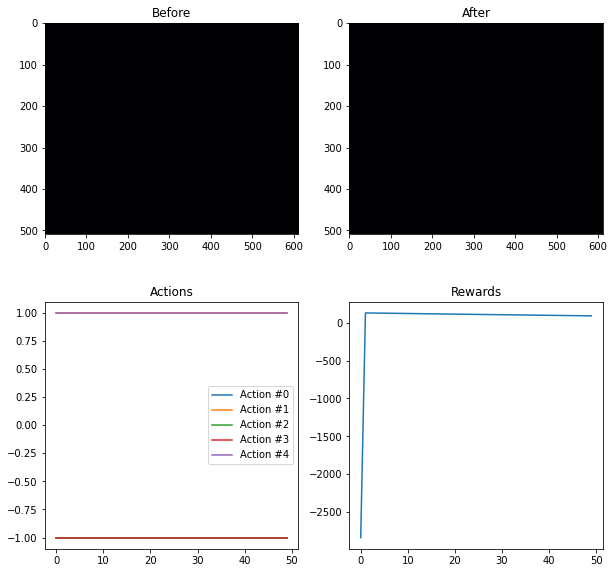

In [5]:
env_monitor = gym.wrappers.Monitor(env, "recordings", video_callable=lambda _: True, force=True)
observation = env_monitor.reset()
before = env_monitor.render()
i = 0
actions = np.zeros((50, n_actions))
rewards = np.zeros(50)
done = False
while not done:
    action, _state = model.predict(observation, deterministic=True)
    actions[i] = action
    observation, reward, done, info = env_monitor.step(action)
    rewards[i] = reward
    i += 1
after = env_monitor.render()
env_monitor.reset()

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("Before")
plt.imshow(before, interpolation="None")
plt.subplot(222)
plt.title("After")
plt.imshow(after, interpolation="None")
plt.subplot(223)
plt.title("Actions")
for i in range(n_actions): plt.plot(actions[:,i], label=f"Action #{i}")
plt.legend()
plt.subplot(224)
plt.title("Rewards")
plt.plot(rewards)
plt.show()